### TODO

- create SSD model
- create masked R-CNN model
- evaluate all the models
- visualize the results

In [4]:
import torch
import torchvision
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, Input
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from ultralytics import YOLO
import random
from PIL import Image
from tensorflow import keras
from tensorflow.image import resize
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [5]:
objects = [
    'ambulance',
    'army vehicle',
    'auto rickshaw',
    'bicycle',
    'bus',
    'car',
    'garbagevan',
    'human hauler',
    'minibus',
    'minivan',
    'motorbike',
    'pickup',
    'policecar',
    'rickshaw',
    'scooter',
    'suv',
    'taxi',
    'three wheelers -CNG-',
    'truck',
    'van',
    'wheelbarrow'
]

train_images = 'trafic_data/train/images'
train_labels = 'trafic_data/train/labels'

In [6]:
def load_data(data_dir, upto=np.inf):
    
    images = []
    annotations = []
    i = 0

    images_dir = os.path.join(data_dir, 'train', 'images')
    labels_dir = os.path.join(data_dir, 'train', 'labels')

    for filename in os.listdir(images_dir):
        if i == upto:
            break
        if filename.endswith('.jpg'):
            img_path = os.path.join(images_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            images.append(img)

            label_path = os.path.join(labels_dir, filename.replace('.jpg', '.txt'))
            with open(label_path, 'r') as f:
                lines = f.readlines()
                boxes = []
                classes = []
                for line in lines:
                    values = line.strip().split()
                    class_id = int(values[0])
                    x, y, w, h = map(float, values[1:])
                    boxes.append([x, y, w, h])
                    
                    classes.append(class_id)
                annotations.append({'boxes': boxes, 'classes': classes})
        
        i += 1
        print(f'For iter {i} collected image: {filename}')

    return np.array(images), annotations

def object_outline(image, annotation, names=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.imshow(image)
    
    for i, box in enumerate(annotation['boxes']):
        x_center, y_center, width, height = box
        
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])
        
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        if names:
            ax.text(x_min, y_min, objects[annotation['classes'][i]], fontsize=12, color='r')
        ax.add_patch(rect)
    
    plt.show()


def process_prepare(annotations):
    max_boxes = max(len(ann['boxes']) for ann in annotations)
    max_classes = max(len(ann['classes']) for ann in annotations)
    
    for ann in annotations:
        ann['boxes'] += [[-1.0, -1.0, -1.0, -1.0]] * (max_boxes - len(ann['boxes']))
        ann['classes'] += [-1] * (max_classes - len(ann['classes']))
    
    boxes_array = np.array([ann['boxes'] for ann in annotations])
    classes_array = np.array([ann['classes'] for ann in annotations])
    
    return boxes_array, classes_array


# YOLOV8


0: 256x416 1 person, 2 trucks, 1390.9ms
Speed: 8.0ms preprocess, 1390.9ms inference, 8.0ms postprocess per image at shape (1, 3, 256, 416)

0: 416x256 2 cars, 1039.1ms
Speed: 7.0ms preprocess, 1039.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 256)

0: 256x416 3 cars, 1 truck, 1006.3ms
Speed: 2.7ms preprocess, 1006.3ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 416)

0: 416x384 2 persons, 2 cars, 1 motorcycle, 1 truck, 1432.5ms
Speed: 0.2ms preprocess, 1432.5ms inference, 8.0ms postprocess per image at shape (1, 3, 416, 384)

0: 416x256 1 person, 1 car, 2 motorcycles, 2 trucks, 1174.0ms
Speed: 0.0ms preprocess, 1174.0ms inference, 8.6ms postprocess per image at shape (1, 3, 416, 256)

0: 256x416 3 persons, 4 cars, 1 motorcycle, 1 bus, 1093.0ms
Speed: 4.1ms preprocess, 1093.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 10 persons, 6 cars, 1 truck, 910.5ms
Speed: 0.0ms preprocess, 910.5ms inference, 0.0ms postprocess 

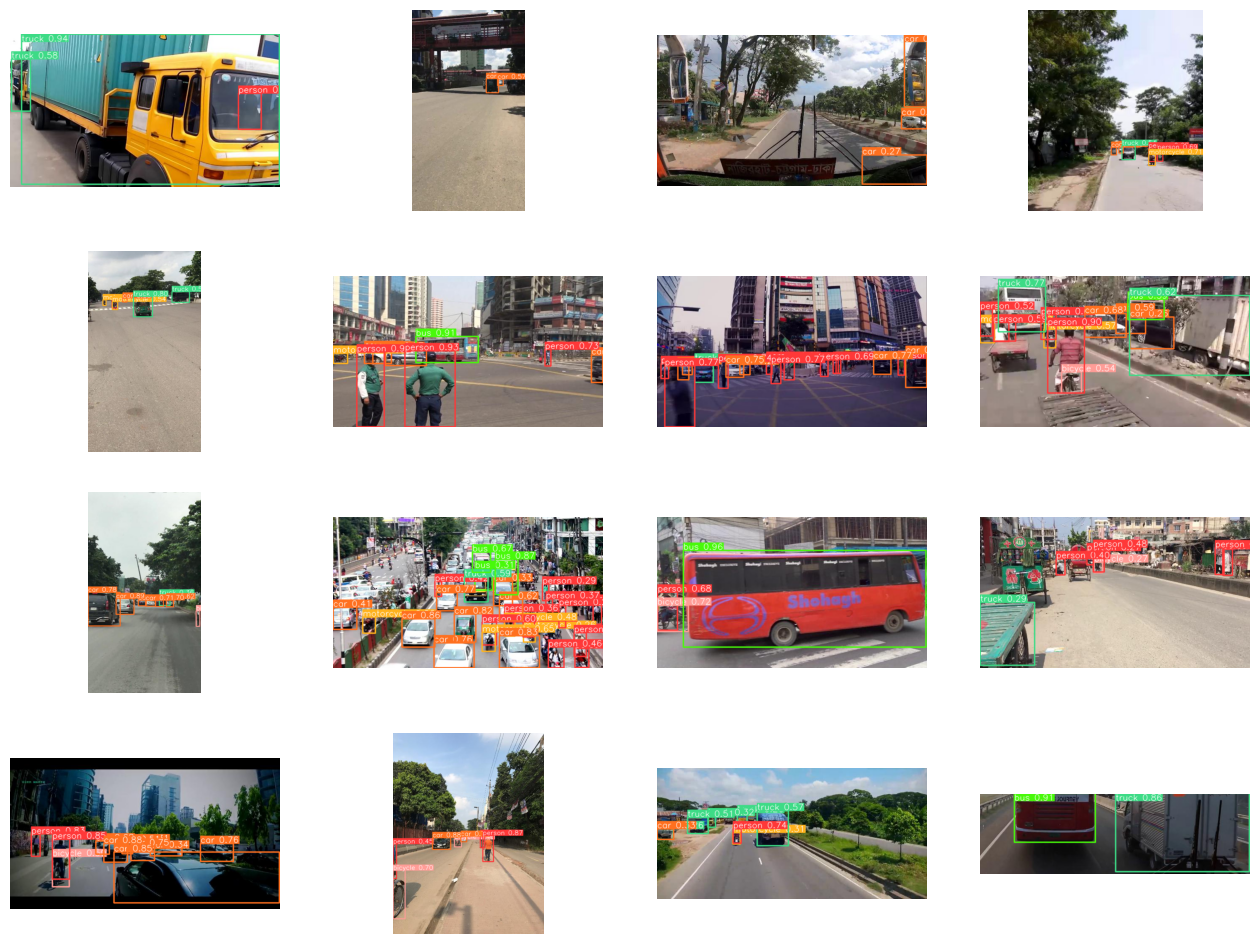

In [17]:
random_images = random.sample(os.listdir(train_images), 16)

model = YOLO("yolov8x.pt") 

fig, axs = plt.subplots(4, 4, figsize = (16, 12))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)
    
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)
    
    result_predict = model.predict(image, imgsz=(416))

    plot = result_predict[0].plot()
    plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

    axs[row,col].imshow(plot)
    axs[row,col].axis('off')

plt.show()

In [51]:
model = YOLO('yolov8x.pt')

model.train(
    data = 'trafic_data/data_1.yaml',
    epochs = 1,
    imgsz = image.shape[0],
    seed = 42,
    batch = 8,
    workers = 4
)


In [ ]:

test_image = cv2.imread('')

result = model(test_image)
result = result[0].plot()
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)


# TENSORFLOW

In [15]:
def create_model(num_classes):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    
    output_locs = layers.Dense(
        4,
        activation='sigmoid',
        name='bounding_box'
    )(x)
    
    output_classes = layers.Dense(num_classes, activation='softmax', name='classes')(x)

    model = Model(inputs=base_model.input, outputs=[output_locs, output_classes])
    
    return model

def train_model(data_dir, num_classes, batch_size=32, epochs=10):
    
    images, annotations = load_data(data_dir, 100)
    boxes_array, classes_array = process_prepare(annotations)

    model = create_model(num_classes)
    model.compile(optimizer='adam', loss=['mse', 'mse'])

    dataset = tf.data.Dataset.from_tensor_slices((images, (boxes_array, classes_array)))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

    model.fit(dataset, epochs=epochs)

    return model


In [14]:
model = train_model('trafic_data', len(objects), batch_size=32, epochs=10)

For iter 1 collected image: 01_jpg.rf.8d8a2f0f90d5b83893cd252acd832c93.jpg
For iter 2 collected image: 02_jpg.rf.65a084066fc353cd023eb5c953f40efe.jpg
For iter 3 collected image: 03_jpg.rf.4532f2db68433995da09f54e215160f3.jpg
For iter 4 collected image: 04_jpg.rf.c0b83432c4d09c7cbeaac18e14c4a54a.jpg
For iter 5 collected image: 05_jpg.rf.11a2e7ce391a1e74960099f7923f27f5.jpg
For iter 6 collected image: 06_jpeg.rf.14bdc2005d8029bbe9f24fad4b6af7ea.jpg
For iter 7 collected image: 07_jpg.rf.8447b11632c1b63ab0e127f16625e0d2.jpg
For iter 8 collected image: 08_jpg.rf.837e69c4e93e62472911c1d18be143a4.jpg
For iter 9 collected image: 09_jpg.rf.42406b1c067f04bf73349bd75b2e3fa8.jpg
For iter 10 collected image: 100_jpg.rf.971dbb99e07828d1655d69bbfb7136be.jpg
For iter 11 collected image: 101_jpg.rf.2737e79396d350c7eeb5bf867c346077.jpg
For iter 12 collected image: 102_jpg.rf.2d884248dcc60b7d6b93f61df77921df.jpg
For iter 13 collected image: 103_jpg.rf.cb820e037e0ccc6163377e9ead1fea10.jpg
For iter 14 coll

# FASTER R_CNN

In [7]:
class My_Dataset(Dataset):
    def __init__(self, images, boxes, classes, transform=None):
        self.images = images
        self.boxes = boxes
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        boxes = self.boxes[idx]
        labels = self.classes[idx]

        if self.transform:
            image = self.transform(image)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        return image, target


In [8]:
images, annotations = load_data('trafic_data', 100)
boxes, classes = process_prepare(annotations)

For iter 1 collected image: 01_jpg.rf.8d8a2f0f90d5b83893cd252acd832c93.jpg
For iter 2 collected image: 02_jpg.rf.65a084066fc353cd023eb5c953f40efe.jpg
For iter 3 collected image: 03_jpg.rf.4532f2db68433995da09f54e215160f3.jpg
For iter 4 collected image: 04_jpg.rf.c0b83432c4d09c7cbeaac18e14c4a54a.jpg
For iter 5 collected image: 05_jpg.rf.11a2e7ce391a1e74960099f7923f27f5.jpg
For iter 6 collected image: 06_jpeg.rf.14bdc2005d8029bbe9f24fad4b6af7ea.jpg
For iter 7 collected image: 07_jpg.rf.8447b11632c1b63ab0e127f16625e0d2.jpg
For iter 8 collected image: 08_jpg.rf.837e69c4e93e62472911c1d18be143a4.jpg
For iter 9 collected image: 09_jpg.rf.42406b1c067f04bf73349bd75b2e3fa8.jpg
For iter 10 collected image: 100_jpg.rf.971dbb99e07828d1655d69bbfb7136be.jpg
For iter 11 collected image: 101_jpg.rf.2737e79396d350c7eeb5bf867c346077.jpg
For iter 12 collected image: 102_jpg.rf.2d884248dcc60b7d6b93f61df77921df.jpg
For iter 13 collected image: 103_jpg.rf.cb820e037e0ccc6163377e9ead1fea10.jpg
For iter 14 coll

In [9]:
train_dataset = My_Dataset(images, boxes, classes, transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

backbone = torchvision.models.resnet50(pretrained=True)
backbone.out_channels = 2048

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

model = FasterRCNN(
    backbone=backbone,
    num_classes=len(objects),
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=None,
    box_head=None,
    box_predictor=None,
    box_detections_per_img=100,
    box_score_thresh=0.05,
    box_nms_thresh=0.5,
    box_fg_iou_thresh=0.5,
    box_bg_iou_thresh=0.5,
    box_batch_size_per_image=512,
    box_positive_fraction=0.25,
    bbox_reg_weights=None
)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


C:\Users\Mashhood\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mashhood\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    print(f'Epoch {epoch + 1}, Loss: {losses.item()}')

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_model.pth')

# MASKED R_CNN

In [ ]:
# model to be implemented

# SSD (Single Shot MultiBox Detector) 

In [ ]:
# model to be implemented